/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_5598/80458853.py:320: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')


  0%|          | 0/493966 [00:00<?, ?it/s]

Calculated...
Total trades: 941
Total pnl -2176.171
Positive trades: 0.499
Negative trades: 0.501
Long trades: 0.577
Short trades: 0.0
StopLoss closes: 0.0
TakeProfit closes: 0.04
endPeriod closes: 0.96


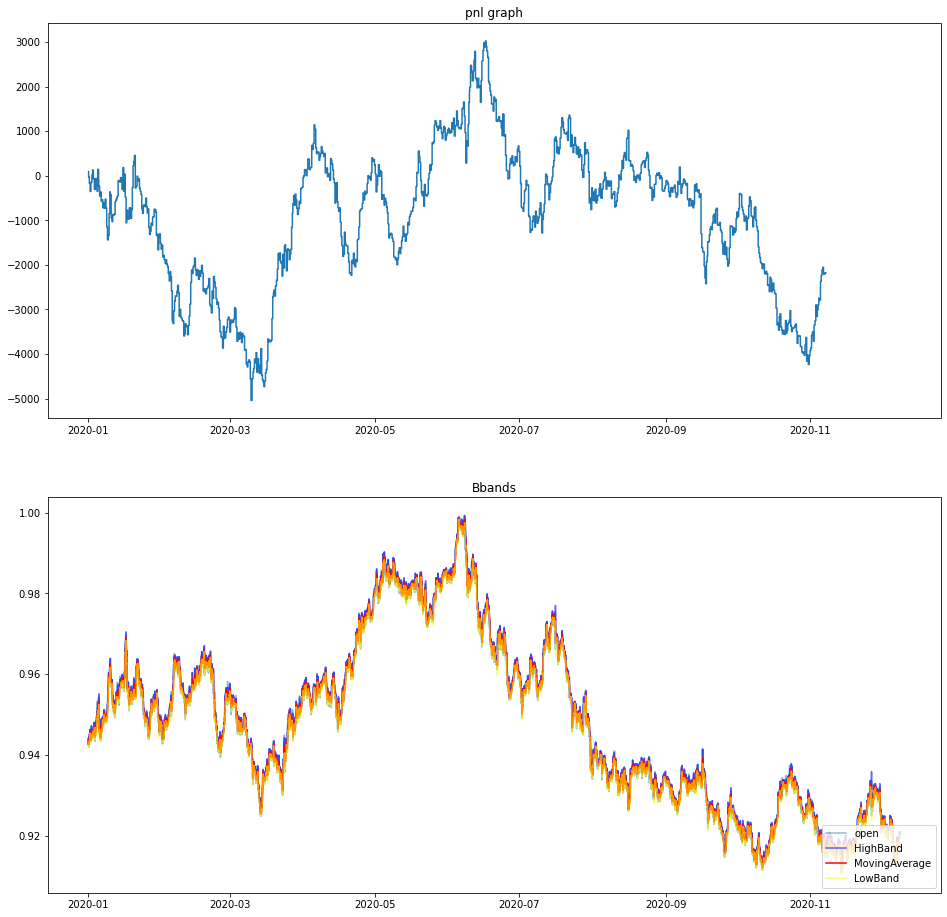

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from timeit import timeit
import sys

from sklearn.model_selection import ParameterGrid

sys.setrecursionlimit(10**8)
inp_data = pd.read_csv('testData/AUDCAD.csv', index_col=1)
# inp_data = pd.read_csv('testData/EURGBP.csv', index_col=0)
inp_data.index = pd.to_datetime(inp_data.index)

"""EURGBP columns rename"""
# inp_data.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, inplace=True)
"""DATABASE columns drop"""
inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

global DataFrequency

DataFrequency = '1T'
def create_grid(pam_grid_obj):
    CAP = 100_000
    slippage = 10
    BuyLossPercent = pam_grid_obj['BuyLossPercent']
    SellLossPercent = pam_grid_obj['BuyLossPercent']
    BuyTakePercent = pam_grid_obj['BuyTakePercent']
    SellTakePercent = pam_grid_obj['BuyTakePercent']
    MaxHold = pam_grid_obj['MaxHold']
    WindowRoll = pam_grid_obj['WindowRoll']
    Y_STD = pam_grid_obj['Y_STD']


    # Массив параметров
    PARAMS = {'Capital': CAP,
              'slippage': slippage,
              'slippagePerCap': slippage / CAP,
              'window_rolling': WindowRoll,
              'Y_threshold': Y_STD,
              'max_hold_period': MaxHold,
              'stopLossesPercent':{
                  'BuyLossPercent': BuyLossPercent / 100,
                  'SellLossPercent': SellLossPercent / 100,
              },
              'takePercent':{
                  'SellTakePercent': BuyTakePercent / 100,
                  'BuyTakePercent': SellTakePercent / 100,
              },
              'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
              'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency))
              }
    del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
    return PARAMS


def calculate_max_drawdown(PNL_SERIES, dollars=True):
    dropout_df = PNL_SERIES.to_frame('pnl')
    dropout_df['hwm'] = dropout_df.expanding().max()
    df0 = dropout_df.groupby('hwm').min().reset_index()
    df0.columns = ['hwm', 'min']
    df0 = df0[df0['hwm'] > df0['min']]
    if dollars:
        dd = df0['hwm'] - df0['min']
    else:
        dd = df0['min'] / df0['hwm']

    return max(dd)

def _estimator(data_frame, params_dict, show=False):
    DF_lines = []
    save_frame = data_frame.copy()
    # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

    # Скользящее среднее
    data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

    # Скользящее отклонение
    data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

    # Отсечение данных имеющих
    # data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

    # Верхний уровень BBand
    data_frame.loc[:, 'HighBBand'] = round(data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

    # Нижний уровень BBand
    data_frame.loc[:, 'LowBBand'] = round(data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),5)

    # Добавление номера линии для удобства
    data_frame['line_number'] = range(1, data_frame.shape[0] + 1)


    # correct_borders2 = data_frame.resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count()
    # correct_borders = tuple(data_frame.open.shift(-1 * params_dict['time_barrier_param']).rolling(params_dict['window_rolling']).count() == float(params_dict['shift_param']))
    ab = list(zip(data_frame.copy().resample(DataFrequency).first().open.shift(-1 * params_dict['time_barrier_param'] - 1).rolling(params_dict['window_rolling']).count().values, data_frame.copy().resample(DataFrequency).first().index))
    ab = pd.DataFrame(ab)
    # print('AB',len(ab))
    # print('DF',len(data_frame))
    ab.columns = ['value', 'time']
    ab.index = ab.time
    ab = ab.drop(['time'], axis=1)

    correct_borders = tuple(pd.merge(data_frame, ab, left_index=True, right_index=True).value == params_dict['shift_param'])
    # print('CB',len(correct_borders))
    dot_low_tuple = tuple(data_frame.low)
    dot_high_tuple = tuple(data_frame.high)
    dot_close_tuple = tuple(data_frame.close)
    LowBBand_tuple = tuple(data_frame.LowBBand)
    HighBBand_tuple = tuple(data_frame.HighBBand)

    cycle_buffer = -10
    ISX = 0
    if show:
        tqdm_bar = tqdm(total=data_frame.shape[0])

    while ISX < (data_frame.shape[0] / 1.1) and (cycle_buffer != ISX):
        openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                     LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                     arrow_index=ISX, openParams=params_dict, correct_borders=correct_borders)

        openLogic['open_time'] = data_frame.index[openLogic['open_index']]
        closeLogic = HoldingPosition(open_logic=openLogic, dot_close_tuple=dot_close_tuple,
                        dot_high_tuple=dot_high_tuple, dot_low_tuple=dot_low_tuple,
                        holdParams=params_dict, arrow_index=openLogic['open_index'] + 1, time_border_counter=0)

        closeLogic['close_time'] = data_frame.index[closeLogic['close_index']]
        summary_dict = openLogic | closeLogic
        DF_lines.append(summary_dict)

        cycle_buffer = ISX
        ISX = closeLogic['close_index']
        if show:
            tqdm_bar.update(ISX - tqdm_bar.last_print_n)

    dfResults = pd.DataFrame(DF_lines)
    dfResults["profit"] = dfResults["position"] * (dfResults["close_price"] - dfResults["open_price"]) - params_dict["slippage"] if (dfResults["type_operation"] == 'BUY').bool else abs(dfResults["position"]) * (dfResults["open_price"] - dfResults["close_price"]) - params_dict["slippage"]
    dfResults.index = dfResults.close_time
    pnl_series = dfResults["profit"].cumsum()


    optimizePar = round(pnl_series[-1] / calculate_max_drawdown(pnl_series + params_dict['Capital']), 4)
    return [dfResults, data_frame, optimizePar]

def OpenPosition(dot_low_tuple, dot_high_tuple, LowBBand_tuple, HighBBand_tuple, arrow_index, openParams, correct_borders):
    """
    Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
    :param current_dot:
    :param arrow_index:
    :return:
    """
    # Задается вид словаря описывающего информацию об открытии сделки
    ret_dict = {'type_operation': None,
                'position': None,
                'open_price': None,
                'open_index': None,
                'stop_loss_border': None,
                'take_profit_border': None
                }
    if arrow_index > len(dot_low_tuple):
        return 'InCorrectData'
    # Проверка о пересечении нижней границы
    if (dot_low_tuple[arrow_index] < LowBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
        ret_dict['type_operation'] = 'BUY'
        ret_dict['position'] = 1 * (openParams['Capital'] / dot_low_tuple[arrow_index])
        ret_dict['open_price'] = dot_low_tuple[arrow_index]
        ret_dict['open_index'] = arrow_index
        ret_dict['stop_loss_border'] = round(dot_low_tuple[arrow_index] * (1 - openParams['stopLossesPercent']['BuyLossPercent']), 5)
        ret_dict['take_profit_border'] = round(dot_low_tuple[arrow_index] * (1 + openParams['takePercent']['BuyTakePercent']), 5)

        return ret_dict
    # Проверка о пересечении верхней границы
    if (dot_low_tuple[arrow_index] > HighBBand_tuple[arrow_index]) and (correct_borders[arrow_index + 1]):
        ret_dict['type_operation'] = 'SELL'
        ret_dict['position'] = -1 * (openParams['Capital'] / dot_low_tuple[arrow_index])
        ret_dict['open_price'] = dot_low_tuple[arrow_index]
        ret_dict['open_index'] = arrow_index

        ret_dict['stop_loss_border'] = round(dot_low_tuple[arrow_index] * (1 + openParams['stopLossesPercent']['SellLossPercent']), 5)
        ret_dict['take_profit_border'] = round(dot_low_tuple[arrow_index] * (1 - openParams['takePercent']['SellTakePercent']), 5)
        return ret_dict
    else:
        return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                            LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                            arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders)

def HoldingPosition(open_logic, dot_close_tuple, dot_high_tuple, dot_low_tuple, holdParams, arrow_index, time_border_counter):
    if open_logic['type_operation'] == 'BUY':
        if time_border_counter - 1 > holdParams['time_barrier_param']:
            return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
        elif dot_low_tuple[arrow_index] <= open_logic['stop_loss_border']:
            return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
        elif dot_high_tuple[arrow_index] >= open_logic['take_profit_border']:
            return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}

        else:
            return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                   dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                   arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)

    if open_logic['type_operation'] == 'SELL':
        if time_border_counter - 1 > holdParams['time_barrier_param']:
            return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index], 'close_index': arrow_index}
        elif dot_low_tuple[arrow_index] <= open_logic['take_profit_border']:
            return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'], 'close_index': arrow_index}
        elif dot_high_tuple[arrow_index] >= open_logic['stop_loss_border']:
            return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'], 'close_index': arrow_index}
        else:
            return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple, dot_high_tuple=dot_high_tuple,
                                   dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                   arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1)
def plotter(test_df, qqq):
    plt.figure(figsize=(16,16))

    ax1 = plt.subplot(4,1,1)
    ax1.set_title('pnl graph')
    plt.step(test_df.open_time, test_df.profit.cumsum().values)
    ax2 = plt.subplot(4,1,2, sharex=ax1)
    ax2.set_title('Bbands')
    plt.plot(qqq.open, label='open', alpha=.5)
    plt.plot(qqq.high, label='high', alpha=.7, color='red')
    plt.plot(qqq.low, label='close', alpha=.7, color='yellow')
    plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
    plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='blue')
    plt.legend(loc='lower right')
    ax3 = plt.subplot(4,1,3, sharex=ax1)
    ax3.set_title('trades histogram')
    for _ in range(test_df.shape[0]):
        if test_df.iloc[_].type_operation == 'BUY':
            plt.axvline(x=test_df.iloc[_].open_time, color='green', alpha=.6, linewidth=.5)
            plt.axvline(x=test_df.iloc[_].close_time, color='green', alpha=.6, linewidth=.5)
        if test_df.iloc[_].type_operation == 'SELL':
            plt.axvline(x=test_df.iloc[_].open_time, color='red', alpha=.6, linewidth=.5)
            plt.axvline(x=test_df.iloc[_].close_time, color='red', alpha=.6, linewidth=.5)
        plt.hlines(xmin=test_df.iloc[_].open_time, xmax=test_df.iloc[_].close_time, y=test_df.open_price[_], color='black', linestyles='-')
    ax4 = plt.subplot(4,1,4, sharex=ax1)

    plt.show()

def lightPlotter(test_df, qqq):
    plt.figure(figsize=(16,16))

    ax1 = plt.subplot(2,1,1)
    ax1.set_title('pnl graph')
    plt.step(test_df.open_time, test_df.profit.cumsum().values)
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    ax2.set_title('Bbands')
    plt.plot(qqq.open, label='open', alpha=.5)
    plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
    plt.plot(qqq.rolling_mean, label='MovingAverage', alpha=1, color='red')
    plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='yellow')
    plt.legend(loc='lower right')

    plt.show()

"""WAY TO DELETE HOLIDAYS"""
# inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
# inp_data.index = inp_data.beautiful_time


# params = {
#     "BuyLossPercent": np.linspace(.5, 5, 4),
#     #"SellLossPercent": [20, 30, 40],
#     "BuyTakePercent": np.linspace(.5, 5, 4),
#     #"SellTakePercent": [20, 30, 40],
#     "MaxHold": [str(x)+'T' for x in np.linspace(100, 450, 6)],
#     "WindowRoll": [str(x)+'T' for x in np.linspace(100, 450, 6)],
#     "Y_STD": np.linspace(10, 200, 6)
#           }
# grid = ParameterGrid(params)
# shuffled = pd.DataFrame(grid).sample(frac=1, random_state=10).reset_index(drop=True)
#
# SHIFT = 400_000
# RESULT = Parallel(n_jobs=-1, verbose=5, prefer="threads", require='sharedmem')(delayed(_estimator)(inp_data.copy().iloc[250_000:].iloc[:SHIFT], create_grid(dict(shuffled.iloc[paramArrow])), show=False) for paramArrow in tqdm(range(shuffled[:30].shape[0])))
#
# optParams = [_[2] for _ in RESULT]
# optParams = shuffled.iloc[optParams.index(max(optParams))]
# print('OPTIMAL_PARAMS:\n', optParams)
# df, preprocessed_data, optimizePar,  = _estimator(data_frame=inp_data.copy().iloc[250_000:].iloc[:SHIFT], params_dict=create_grid(dict(optParams)), show=True)
# # plotter(df, preprocessed_data)
# lightPlotter(df, preprocessed_data)
# print('INSAMPLE')
# print(f"Total trades:", df.shape[0])
# print(f"Total pnl", round(df.profit.cumsum().iloc[-1], 3))
# print(f"Positive trades:", round(df[df.profit > 0].shape[0] / df.shape[0], 3))
# print(f"Negative trades:", round(df[df.profit < 0].shape[0] / df.shape[0], 3))
# print(f"Long trades:", round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3))
# print(f"Short trades:", round(df[df.type_operation == 'SELLT'].shape[0] / df.shape[0], 3))
# print(f"StopLoss closes:", round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3))
# print(f"TakeProfit closes:", round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3))
# print(f"endPeriod closes:", round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3))
#
# df, preprocessed_data, optimizePar = _estimator(data_frame=inp_data.copy().loc['2020-03':], params_dict=create_grid(dict(optParams)), show=True)
# # plotter(df, preprocessed_data)
# lightPlotter(df, preprocessed_data)
# print('OUTOFSAMPLE')
# print(f"Total trades:", df.shape[0])
# print(f"Total pnl", round(df.profit.cumsum().iloc[-1], 3))
# print(f"Positive trades:", round(df[df.profit > 0].shape[0] / df.shape[0], 3))
# print(f"Negative trades:", round(df[df.profit < 0].shape[0] / df.shape[0], 3))
# print(f"Long trades:", round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3))
# print(f"Short trades:", round(df[df.type_operation == 'SELLT'].shape[0] / df.shape[0], 3))
# print(f"StopLoss closes:", round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3))
# print(f"TakeProfit closes:", round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3))
# print(f"endPeriod closes:", round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3))
# """=============================================================================================================================="""


params = {
    "BuyLossPercent": 3.5,
    #"SellLossPercent": [20, 30, 40],
    "BuyTakePercent": .5,
    #"SellTakePercent": [20, 30, 40],
    "MaxHold": '450T',
    "WindowRoll": '170T',
    "Y_STD": 162
          }

inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
inp_data.index = inp_data.beautiful_time
SHIFT = 400_000
df, preprocessed_data, optimizePar,  = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-01'], params_dict=create_grid(params), show=True)
print('Calculated...')
lightPlotter(df, preprocessed_data)
print(f"Total trades:", df.shape[0])
print(f"Total pnl", round(df.profit.cumsum().iloc[-1], 3))
print(f"Positive trades:", round(df[df.profit > 0].shape[0] / df.shape[0], 3))
print(f"Negative trades:", round(df[df.profit < 0].shape[0] / df.shape[0], 3))
print(f"Long trades:", round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3))
print(f"Short trades:", round(df[df.type_operation == 'SELLT'].shape[0] / df.shape[0], 3))
print(f"StopLoss closes:", round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3))
print(f"TakeProfit closes:", round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3))
print(f"endPeriod closes:", round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3))

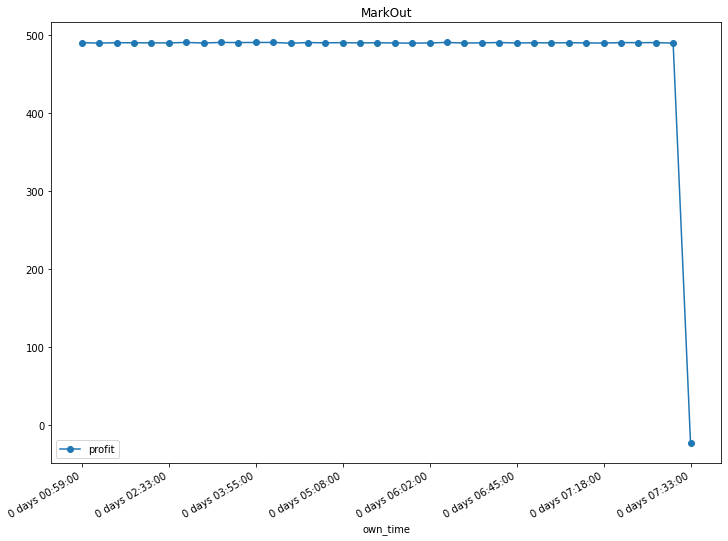

In [22]:
df["own_time"] = df.close_time - df.open_time
plt.figure(figsize=(12,9))
plt.title('MarkOut')
ax = plt.subplot(1,1,1)
df.groupby(by='own_time').profit.mean().plot(marker='o', ax=ax)
plt.legend(loc='lower left')
plt.show()

(array([   60000000000,   120000000000,   300000000000,   600000000000,
         1200000000000,  1320000000000,  1800000000000,  1920000000000,
         2160000000000,  2460000000000,  2640000000000,  2760000000000,
         2820000000000,  2880000000000,  3000000000000,  3420000000000,
         3660000000000,  4080000000000,  4680000000000,  5040000000000,
         5220000000000,  5400000000000,  5820000000000,  6300000000000,
         6660000000000,  6840000000000,  6960000000000,  7080000000000,
         7440000000000,  8280000000000,  8460000000000,  8520000000000,
         8700000000000,  9060000000000,  9120000000000,  9180000000000,
         9420000000000, 10740000000000, 10920000000000, 11100000000000,
        11760000000000, 11820000000000, 12420000000000, 12480000000000,
        12540000000000, 12600000000000, 14160000000000, 14400000000000,
        14640000000000, 15180000000000, 15420000000000, 15780000000000,
        16440000000000, 16680000000000, 16860000000000, 16980000